# Fit Multiple Noisy Traces HH to HH

In [1]:
import pandas as pd
import numpy as np

In [2]:
from brian2 import *
from brian2tools import *

prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


In [3]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

dt = 0.01*ms
defaultclock.dt = dt

In [4]:
params_correct

{'gl': 1e-08, 'g_na': 2e-05, 'g_kd': 6e-06}

### Load Input and Output

In [5]:
df_inp_traces = pd.read_csv('input_traces_hh.csv')
df_out_traces = pd.read_csv('output_traces_hh.csv')

In [6]:
inp_traces = df_inp_traces.to_numpy()
inp_traces = inp_traces[:, 1:]
inp_traces

array([[0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       [2.e-09, 2.e-09, 2.e-09, ..., 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00]])

In [7]:
out_traces = df_out_traces.to_numpy()
out_traces = out_traces[:, 1:]
out_traces

array([[-63.54211145, -65.52491616, -62.90054542, ..., -81.5252667 ,
        -82.30107475, -82.04870895],
       [-63.78548155, -64.75587972, -64.60550311, ..., -64.42127691,
        -65.13069593, -64.48718384],
       [-62.92648395, -65.82540807, -64.76394825, ..., -64.9418292 ,
        -63.8704734 , -63.17105741],
       [-64.51645049, -66.84945425, -64.64260378, ..., -80.91299455,
        -79.08977935, -82.01562544],
       [-65.57417095, -65.68558642, -65.67498994, ..., -59.60054522,
        -60.47494105, -60.01392187]])

## Model Fitting 

In [8]:
# Model for modelfitting
eqs = Equations(
'''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
Cm   : farad (constant)
''',
# El  : volt(constant)
# EK  : volt(constant)
# ENa : volt(constant)
# Cm=1*ufarad*cm**-2 * area,
El=-65*mV, EK=-90*mV, ENa=50*mV,
VT=-63*mV)

In [ ]:
def callback(res, errors, parameters, index):
    print('index {} errors minimum: {}'.format(index, min(errors)) )

In [9]:
start_scope()
n_opt = SkoptOptimizer()
metric = MSEMetric()

res, error = fit_traces_standalone(model=eqs, input_var='I', output_var='v',
                                   input=inp_traces * amp, output=out_traces*mV, dt=dt,
                                   callback=callback, 
                                   method='exponential_euler',
                                   gl = [1e-09 *siemens, 1e-07 *siemens],
                                   g_na = [2e-06*siemens, 2e-04*siemens],
                                   g_kd = [6e-07*siemens, 6e-05*siemens],
                                   Cm=[0.1*ufarad*cm**-2 * area, 2*ufarad*cm**-2 * area],
#                                    El=[-100*mV, -60*mV],
#                                    EK=[-100*mV, -60*mV],
#                                    ENa=[30*mV, 55*mV],
                                   n_rounds=10, n_samples=30, optimizer=n_opt, 
                                   metric=metric)

index_param (array([7, 7, 7, 7]), array([0, 1, 2, 3]))
errors [1.25545698 2.14134039 1.17000074 0.88077349 1.33552317 1.02886497
 1.58388982 0.84972781 1.65539837 1.64977949 3.71800616 1.55686457
 0.96592158 1.4388703  5.74955408 1.68718967 1.89563763 3.20404153
 1.99726236 1.60249603]
round 0 with error [0.84972781 0.84972781 0.84972781 0.84972781]


WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
 [py.warnings]


index_param (array([ 0,  0,  1,  1,  1,  2,  3,  3,  5,  5,  5,  5,  6,  8,  9,  9, 11,
       11, 12, 13, 14, 14, 15, 15, 15, 16, 16, 17, 19]), array([1, 3, 0, 1, 3, 1, 1, 3, 0, 1, 2, 3, 1, 3, 1, 3, 0, 3, 1, 1, 1, 3,
       0, 1, 3, 1, 3, 3, 1]))
errors [1.18340402 0.83869931 1.51730876 1.32982708 0.86745076 0.83624084
 1.4538176  1.15178113 1.42563767 1.01579659 0.91323835 0.83626118
 1.28358808 1.46216974 1.01670633 0.84097698 4.72493792 1.11574793
 1.10099111 1.21115923]
round 1 with error [1.18340402 1.18340402 0.83869931 0.83869931 0.83869931 1.51730876
 1.32982708 1.32982708 0.83624084 0.83624084 0.83624084 0.83624084
 1.4538176  1.42563767 1.01579659 1.01579659 0.83626118 0.83626118
 1.28358808 1.46216974 1.01670633 1.01670633 0.84097698 0.84097698
 0.84097698 4.72493792 4.72493792 1.11574793 1.21115923]
index_param (array([ 0,  0,  2,  4,  5,  5,  6,  7,  7,  8,  9, 10, 11, 14, 15, 16, 16,
       16, 17, 17, 18, 19, 19]), array([0, 3, 0, 0, 0, 3, 0, 0, 1, 0, 3, 0, 3, 3, 3, 0, 

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
 [py.warnings]


index_param (array([ 1,  2,  3,  5,  5,  5,  5,  6,  7,  8,  9, 10, 12, 14, 15, 16, 17,
       18, 19]), array([0, 0, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
errors [0.81688256 0.75963781 0.70801317 0.70317472 0.82643873 0.7008527
 0.80427906 0.75824316 0.99857499 0.9104242  0.71141401 0.83399035
 0.91975224 0.81882271 0.71069987 0.93695376 0.94261925 0.84431199
 0.7996064  0.71712063]
round 4 with error [0.75963781 0.70801317 0.70317472 0.7008527  0.7008527  0.7008527
 0.7008527  0.80427906 0.75824316 0.99857499 0.9104242  0.71141401
 0.91975224 0.71069987 0.93695376 0.94261925 0.84431199 0.7996064
 0.71712063]


WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
 [py.warnings]


index_param (array([ 0,  1,  2,  2,  4,  7,  7,  8,  9,  9, 14, 14, 16, 17, 17, 17, 17,
       19]), array([0, 0, 0, 3, 3, 0, 3, 3, 0, 3, 0, 3, 3, 0, 1, 2, 3, 3]))
errors [0.67844933 0.68255175 0.68718564 0.79542022 0.82166093 0.81919737
 0.85413446 0.6893451  0.85765328 0.68096307 0.87693064 0.91653157
 0.94010548 0.90390724 0.70599844 0.91864797 0.76914242 0.6652321
 0.78809562 0.83075452]
round 5 with error [0.67844933 0.68255175 0.68718564 0.68718564 0.82166093 0.6893451
 0.6893451  0.85765328 0.68096307 0.68096307 0.70599844 0.70599844
 0.76914242 0.6652321  0.6652321  0.6652321  0.6652321  0.83075452]
index_param (array([0, 1, 2, 8]), array([3, 3, 3, 3]))
errors [1.7181051  1.66886541 1.69180681 1.67461792 1.93860794 1.93882659
 1.93628049 1.76190095 1.6809847  1.80848499 1.73275823 1.99790128
 1.77193244 1.95732765 1.88655678 1.86602079 1.8173891  1.91528457
 2.03908431 1.70593432]
round 6 with error [1.7181051  1.66886541 1.69180681 1.6809847 ]
index_param (array([], dtype=int6

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
 [py.warnings]


index_param (array([ 0,  0,  1,  2,  2,  2,  2,  3,  3,  4,  5,  5,  6,  7,  8, 11, 12]), array([0, 3, 0, 0, 1, 2, 3, 0, 3, 0, 0, 3, 3, 0, 3, 0, 0]))
errors [0.7034622  0.78984994 0.65233215 0.66630243 0.76591463 0.97600534
 0.90446326 1.05736088 0.86635608 0.90077677 0.81701577 0.75985115
 1.02516653 0.95211967 1.11189953 1.11599032 1.12277611 1.2239053
 1.35415193 1.31075171]
round 9 with error [0.7034622  0.7034622  0.78984994 0.65233215 0.65233215 0.65233215
 0.65233215 0.66630243 0.66630243 0.76591463 0.97600534 0.97600534
 0.90446326 1.05736088 0.86635608 0.75985115 1.02516653]


In [10]:
# get information to the optimizer
print('correct:', params_correct, '\n output:', res)
print('error', error)

correct: {'gl': 1e-08, 'g_na': 2e-05, 'g_kd': 6e-06} 
 output: {'g_na': 2e-06, 'Cm': 1.203927425455891e-10, 'g_kd': 9.084293988089247e-06, 'gl': 1e-07}
error [0.7034622  0.7034622  0.78984994 0.65233215 0.65233215 0.65233215
 0.65233215 0.66630243 0.66630243 0.76591463 0.97600534 0.97600534
 0.90446326 1.05736088 0.86635608 0.75985115 1.02516653]


## Results Visualization

In [11]:
# visualization of the results
start_scope()
fits = generate_fits(model=eqs, method='exponential_euler', params=res,
                     input=inp_traces * amp, input_var='I', output_var='v',
                     dt=dt, param_init={'v': -65*mV})

fits/mV

array([[-65.        , -65.        , -65.        , ..., -65.48109468,
        -65.47712415, -65.4731863 ],
       [-65.        , -65.        , -65.        , ..., -64.90147952,
        -64.90230268, -64.9031189 ],
       [-65.        , -64.83456504, -64.67049853, ..., -65.18905567,
        -65.18749382, -65.1859448 ],
       [-65.        , -65.        , -65.        , ..., -65.55060282,
        -65.54605245, -65.5415396 ],
       [-65.        , -65.        , -65.        , ..., -64.96741274,
        -64.96767629, -64.96793765]])

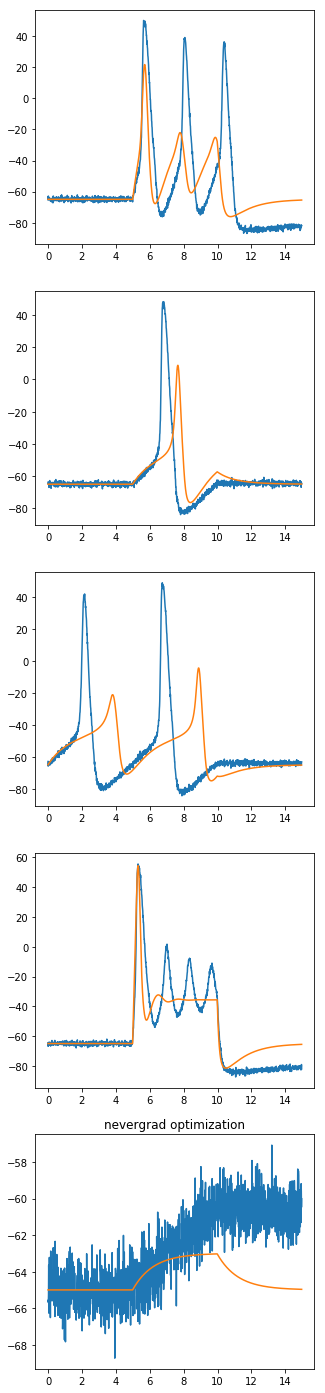

In [12]:
fig, ax = plt.subplots(nrows=5, figsize=(5, 25))
ax[0].plot(np.arange(len(out_traces[0]))*dt/ms, out_traces[0]);
ax[0].plot(np.arange(len(fits[0]))*dt/ms, fits[0]/mV);

ax[1].plot(np.arange(len(out_traces[1]))*dt/ms, out_traces[1]);
ax[1].plot(np.arange(len(fits[1]))*dt/ms, fits[1]/mV);

ax[2].plot(np.arange(len(out_traces[2]))*dt/ms, out_traces[2]);
ax[2].plot(np.arange(len(fits[2]))*dt/ms, fits[2]/mV);

ax[3].plot(np.arange(len(out_traces[3]))*dt/ms, out_traces[3]);
ax[3].plot(np.arange(len(fits[3]))*dt/ms, fits[3]/mV);

ax[4].plot(np.arange(len(out_traces[4]))*dt/ms, out_traces[4]);
ax[4].plot(np.arange(len(fits[4]))*dt/ms, fits[4]/mV);

plt.title('nevergrad optimization')
plt.show()